# BDA ANALYSEPROJEKT MIETPREISE DEUTSCHLAND 2023


## Betriebswirtschaftliche Datenanalyse – Exposé

### Teammitglieder

| Vorname   | Nachname  | Matrikelnummer |
|-----------|-----------|----------------|
| Timon     | Schmidt   | 217101         |
| Sümeyye   | Gügercin  | 214424         |
| Melih     | Akbulut   | 220860         |
| Dariana   | Barkov    | 220858         |
| Rasmus    | Wegat     | 221727         |

---

### Fragestellung

**„Gibt es einen klaren Zusammenhang zwischen Leerstand und Mietpreisen in Deutschland?“**

---

### Erläuterung

In dieser Analyse sollen die Daten zu leerstehenden Wohnungen und den Wohnungspreisen in den jeweiligen Landkreisen aus dem Jahr 2023 verglichen werden. Ziel ist es, zu untersuchen, ob in attraktiven Städten mit hohen Mieten ein künstlicher Wohnungsleerstand existiert, um durch eine künstliche Verknappung die Preise hochzuhalten. Darüber hinaus sollen weitere Muster identifiziert werden, um die Haupttreiber hoher Mietpreise in Großstädten besser zu verstehen.

---

### Ansatz und Vorgehensweise

Mit Hilfe von **pandas**, **matplotlib** und **seaborn** werden die Leerstandsquoten und Mietpreise auf Kreisebene anhand der Daten des Deutschlandatlas analysiert und visualisiert. Zusätzlich können weitere Einflussfaktoren wie Bevölkerungsdichte, Einkommen und Urbanität einbezogen werden, um weitere Aussagen über Ursachen hoher Mietpreise treffen zu können.

---

### Datenquelle

[Deutschlandatlas – Mieten](https://www.deutschlandatlas.bund.de/DE/Karten/Wie-wir-wohnen/040-Mieten.html#_g5f1sd6f4)  
Aufgerufen am 13.04.2025, 13:00 Uhr.

Imports

In [68]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
from scipy.stats import lognorm, kstest, norm, shapiro, zscore

%matplotlib inline

Einlesen der Exel Datei und herausfiltern der Daten die wir wollen


In [69]:

gem1222 = pd.read_excel("Deutschlandatlas-Daten.xlsx", sheet_name="Deutschlandatlas_GEM1222")
vbgem1222 = pd.read_excel("Deutschlandatlas-Daten.xlsx", sheet_name="Deutschlandatlas_VBGEM1222")
krs1222 = pd.read_excel("Deutschlandatlas-Daten.xlsx", sheet_name="Deutschlandatlas_KRS1222")
krs1221 = pd.read_excel("Deutschlandatlas-Daten.xlsx", sheet_name="Deutschlandatlas_KRS1221")
krs1220 = pd.read_excel("Deutschlandatlas-Daten.xlsx", sheet_name="Deutschlandatlas_KRS1220")
def rename_key(df):
    return df.rename(columns={df.columns[0]: "KRS_ID"})

gem1222 = rename_key(gem1222)
vbgem1222 = rename_key(vbgem1222)
krs1222 = rename_key(krs1222)
krs1221 = rename_key(krs1221)
krs1220 = rename_key(krs1220)

gem_cols = ["KRS_ID", "Gemeindename", "bev_dicht", "bev_entw", "beschq_insg"]
vbgem_cols = ["KRS_ID", "Gemeindeverbandsname", "pendel"]
krs1222_cols = ["KRS_ID", "Kreisname", "bev_binw", "preis_miet", "wohn_eigen", "wohn_leer", "wohn_EZFH", "wohn_MFH",
                "erw_wachs", "erw_mini", "erw_minineben", "alq", "schulden", "sozsich", "straft", "einbr"]
krs1221_cols = ["KRS_ID", "Kreisname", "preis_baul", "erw_bip", "hh_veink"]
krs1220_cols = ["KRS_ID", "Kreisname", "erw_vol"]

gem1222_sel = gem1222[gem_cols]
vbgem1222_sel = vbgem1222[vbgem_cols]
krs1222_sel = krs1222[krs1222_cols]
krs1221_sel = krs1221[krs1221_cols]
krs1220_sel = krs1220[krs1220_cols]

df = krs1222_sel.merge(krs1221_sel, on=["KRS_ID", "Kreisname"], how="left", suffixes=("", "_krs1221"))
df = df.merge(krs1220_sel, on=["KRS_ID", "Kreisname"], how="left", suffixes=("", "_krs1220"))
df = df.merge(vbgem1222_sel, on="KRS_ID", how="left")
df = df.merge(gem1222_sel, on="KRS_ID", how="left")

df = df.sort_values("KRS_ID").reset_index(drop=True)
df.to_excel("ExtractedData.xlsx", index=False)


**Legende der Kombinierten Tabelle**

- **bev_dicht**: Bevölkerungsdichte (Einwohner je km²)
- **bev_entw**: Bevölkerungsentwicklung (% zum Vorjahr)
- **beschq_insg**: Beschäftigungsquote insgesamt (%)
- **pendel**: Pendleranteil bzw. Pendlerbewegung
- **bev_binw**: Bevölkerungsentwicklung insgesamt (%-Veränderung)
- **preis_miet**: Angebotsmietpreis in €/m²
- **wohn_eigen**: Anteil der selbstgenutzten Immobilien (%)
- **wohn_leer**: Leerstandsquote (%)
- **wohn_EZFH**: Anteil an Ein- und Zweifamilienhäusern (%)
- **wohn_MFH**: Anteil an Mehrfamilienhäusern (%)
- **erw_wachs**: Erwerbstätigenwachstum (%)
- **erw_mini**: Anteil der Minijobs (%)
- **erw_minineben**: Anteil der Minijobs als Nebentätigkeit (%)
- **alq**: Arbeitslosenquote (%)
- **schulden**: Verschuldung je Einwohner (in €)
- **sozsich**: Anteil an der Bevölkerung in sozialer Sicherung (%)
- **straft**: Straftaten pro 100.000 Einwohner
- **einbr**: Einbruchshäufigkeit pro 100.000 Einwohner
- **preis_baul**: Baulandpreise (Textkategorie, z. B. „100 bis unter 200 €/m²“)
- **erw_bip**: Bruttoinlandsprodukt (BIP) je Erwerbstätigen (in Tsd. €)
- **hh_veink**: Verfügbares Einkommen je Einwohner (in Tsd. €)
- **erw_vol**: Anteil der Vollzeit-Erwerbstätigen an allen Erwerbstätigen (%)

## 1. Der Zusammenhang von Leerstand und Mietpreisen

**Gibt es einen direkten Zusammenhang Zwischen Leerstand und Mietpreisen von Wohnungen?**

- Scatterpolt und Trendline
- Korrelationsanalyse (Pearson/Spearman)
- Regionale Ausreißer


In [70]:
df1 = df.copy()
preis_miet_order = [
	"bis unter 5,50",
	"5,50 bis unter 7,00",
	"7,00 bis unter 8,50",
	"8,50 bis unter 10,00",
	"10,00 bis unter 11,50",
	"11,50 und mehr"
]
df1['preis_miet_cat'] = pd.Categorical(df['preis_miet'], categories=preis_miet_order, ordered=True)

In [71]:
df1['preis_miet'].value_counts().reindex(preis_miet_order[::-1]).rename('Anzahl').rename_axis('Mietpreiskategorie').reset_index()

,Mietpreiskategorie,Anzahl
0,"11,50 und mehr",46
1,"10,00 bis unter 11,50",59
2,"8,50 bis unter 10,00",101
3,"7,00 bis unter 8,50",122
4,"5,50 bis unter 7,00",70
5,"bis unter 5,50",2


In [72]:
anzahl = df1['preis_miet'].value_counts().reindex(preis_miet_order)
print(f"Anzahl der Kreise: {len(df)}")
for seg, n in anzahl.items():
    prozent = n / len(df1) * 100 if n is not None else 0
    print(f"{seg:<22}: {n:3} Kreise ({prozent:5.2f}%)")

Anzahl der Kreise: 400
bis unter 5,50        :   2 Kreise ( 0.50%)
5,50 bis unter 7,00   :  70 Kreise (17.50%)
7,00 bis unter 8,50   : 122 Kreise (30.50%)
8,50 bis unter 10,00  : 101 Kreise (25.25%)
10,00 bis unter 11,50 :  59 Kreise (14.75%)
11,50 und mehr        :  46 Kreise (11.50%)


**1.1 Wie hoch sind die Mieten in Deutschen Kreisen?**

Über die Hälfte (55,75%) aller Kreise befinden sich im mittleren Bereich zwischen 7,00 und 10,00 €. 46 Kreise überschreiten die Marke von 11,50 €, während extrem günstige Mieten mit unter 5,50 € nur noch in 2 Kreisen vorkommen. Das zeigt, dass zwar viele Regionen noch moderate Mieten haben, der besonders günstige Wohnraum aber fast vollständig verschwunden ist und hochpreisige Regionen zunehmen.

Zur Veranschaulichung der Verteilung der Mietpreise lassen diese sich in einem Diagramm mit Dichte-Overlay darstellen.

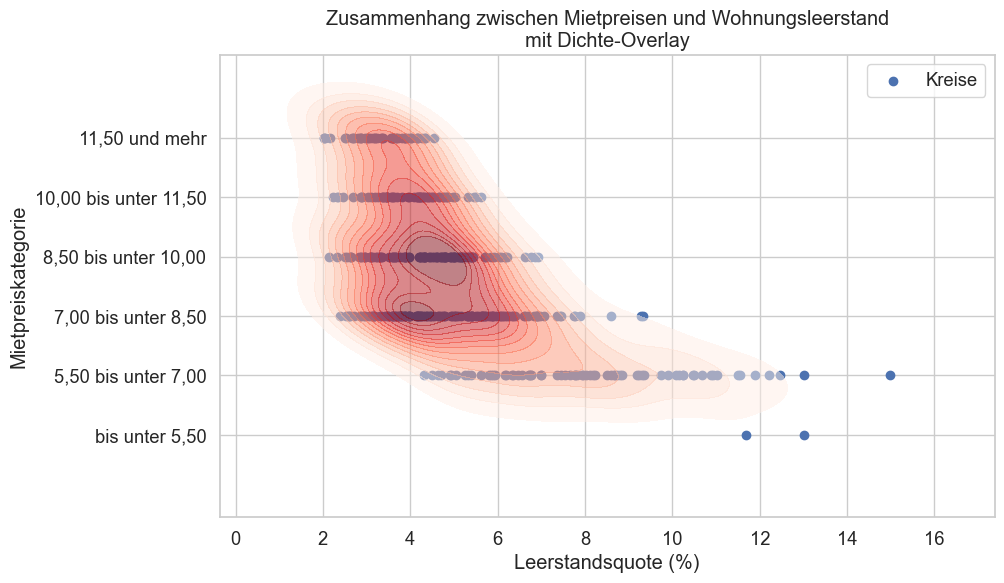

In [73]:
x = df1['wohn_leer']
y = df1['preis_miet_cat'].cat.codes
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=1, label='Kreise')
sns.kdeplot(x=x, y=y, cmap="Reds", fill=True, thresh=0.05, alpha=0.5, levels=15)
plt.xlabel('Leerstandsquote (%)')
plt.ylabel('Mietpreiskategorie')
plt.yticks(range(len(preis_miet_order)), preis_miet_order)
plt.title('Zusammenhang zwischen Mietpreisen und Wohnungsleerstand\nmit Dichte-Overlay')
plt.grid(True)
plt.legend()
plt.show()


**1.2 Interpretation der Datenverteilung**
    
Konträr zu der ursprünglichen Annahme das Mietpreise durch Künstliche Knappheit angehoben werden könnten, ist der Trend klar erkennbar, dass Mieten in jenen Kreisen höher sind, wo auch eine geringe Leerstandsquote herrscht. Völlig lässt sich dies dadurch nicht ausschließen, da in einzelfällen, dies immermoch die intention sein könnte, aber es wiederlegt eine Verbreitete Verwendung dieser Methode.

Um den zusammenhang klarer darzustellen lässt sich eine Regressionsgerade in diesem Diagramm zeichen. Dieser zusammenhang lässt sich auch Numerarisch nach Pearson und Spearman aufweisen.

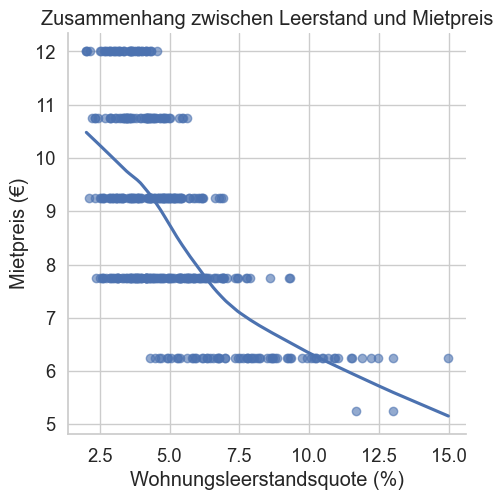

In [74]:
preis_map = {
    "bis unter 5,50": 5.25,
    "5,50 bis unter 7,00": 6.25,
    "7,00 bis unter 8,50": 7.75,
    "8,50 bis unter 10,00": 9.25,
    "10,00 bis unter 11,50": 10.75,
    "11,50 und mehr": 12.0
}
df1['preis_miet_num'] = df1['preis_miet'].map(preis_map)
sns.lmplot(x='wohn_leer', y='preis_miet_num', data=df1, lowess=True, scatter_kws={'alpha':0.6})
plt.title('Zusammenhang zwischen Leerstand und Mietpreis')
plt.xlabel('Wohnungsleerstandsquote (%)')
plt.ylabel('Mietpreis (€)')
plt.show()

In [75]:
pearson_corr = df1[['preis_miet_num', 'wohn_leer']].corr(method='pearson').iloc[0,1]
spearman_corr = df1[['preis_miet_num', 'wohn_leer']].corr(method='spearman').iloc[0,1]
print(f"Pearson-Korrelation: {pearson_corr:.2f}")
print(f"Spearman-Korrelation: {spearman_corr:.2f}")

Pearson-Korrelation: -0.63
Spearman-Korrelation: -0.63


**1.3 Der Zusammenhang Beschrieben**

Die Analyse zeigt einen mittleren bis starken negativen Zusammenhang zwischen Mietpreisen und Leerstandsquoten in deutschen Kreisen. Das bedeutet in Regionen mit hoher Leerstandsquote sind die Mieten tendenziell niedriger. Dieser Zusammenhang ist sowohl mit dem Spearman- als auch mit dem Pearson-Korrelationskoeffizienten nachweisbar und damit robust gegenüber Ausreißern.

/var/folders/pp/gf_3tzkn0696r915yh2j6m1r0000gn/T/ipykernel_42421/4244957786.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df1.groupby('preis_miet_cat')
/var/folders/pp/gf_3tzkn0696r915yh2j6m1r0000gn/T/ipykernel_42421/4244957786.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers = grouped.apply(find_outliers).reset_index(drop=True)


,Kreisname,preis_miet,wohn_leer
0,Wunsiedel i.Fichtelgebirge,"7,00 bis unter 8,50",9.27
1,Prignitz,"7,00 bis unter 8,50",9.33


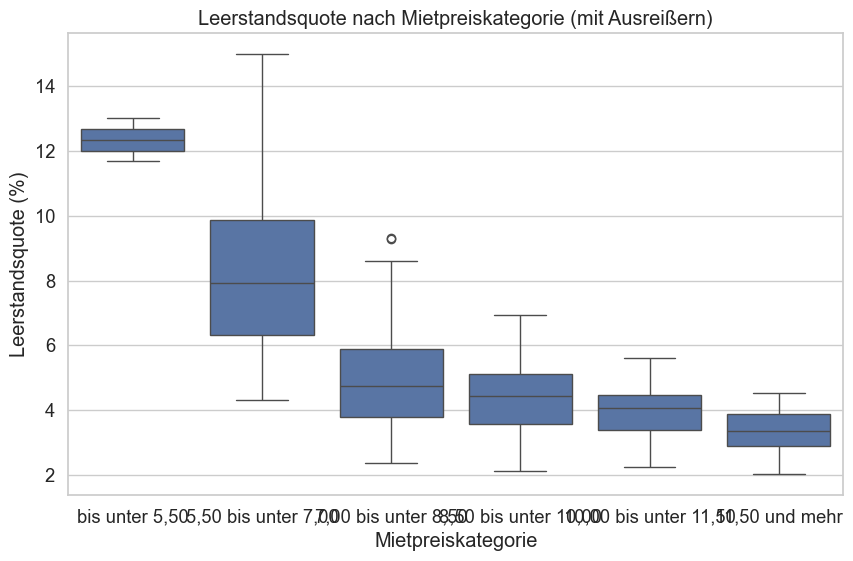

In [76]:
# Ausreißeranalyse der Leerstandsquote pro Mietpreiskategorie

def find_outliers(group):
    q1 = group['wohn_leer'].quantile(0.25)
    q3 = group['wohn_leer'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return group[(group['wohn_leer'] < lower) | (group['wohn_leer'] > upper)]

# Ausreißer pro Mietpreiskategorie finden
grouped = df1.groupby('preis_miet_cat')
outliers = grouped.apply(find_outliers).reset_index(drop=True)

# Tabellarische Ausgabe
display_cols = [col for col in ['Kreisname', 'preis_miet', 'wohn_leer'] if col in df1.columns]
display(outliers[display_cols])

# Grafische Darstellung
plt.figure(figsize=(10,6))
sns.boxplot(x='preis_miet_cat', y='wohn_leer', data=df1, showfliers=True)
plt.title('Leerstandsquote nach Mietpreiskategorie (mit Ausreißern)')
plt.ylabel('Leerstandsquote (%)')
plt.xlabel('Mietpreiskategorie')
plt.show()


In [78]:
result_rows = []
for cat, group in df1.groupby('preis_miet_cat'):
    top2 = group.nlargest(2, 'wohn_leer')
    bottom2 = group.nsmallest(2, 'wohn_leer')
    for _, row in top2.iterrows():
        result_rows.append({
            'Kategorie': cat,
            'Typ': 'Höchste Leerstandsquote',
            'Kreisname': row.get('Kreisname', ''),
            'Leerstandsquote': row['wohn_leer'],
            'Mietpreis': row['preis_miet']
        })
    for _, row in bottom2.iterrows():
        result_rows.append({
            'Kategorie': cat,
            'Typ': 'Niedrigste Leerstandsquote',
            'Kreisname': row.get('Kreisname', ''),
            'Leerstandsquote': row['wohn_leer'],
            'Mietpreis': row['preis_miet']
        })
extremes_df = pd.DataFrame(result_rows)
extremes_df = extremes_df.sort_values(['Kategorie', 'Typ', 'Leerstandsquote'], ascending=[True, True, False])

display(extremes_df)

top2_leer = df1.nlargest(2, 'wohn_leer')[['Kreisname', 'wohn_leer', 'preis_miet']]
bottom2_leer = df1.nsmallest(2, 'wohn_leer')[['Kreisname', 'wohn_leer', 'preis_miet']]

print("Top 2 höchste Leerstandsquoten insgesamt:")
display(top2_leer)
print("Top 2 niedrigste Leerstandsquoten insgesamt:")
display(bottom2_leer)

/var/folders/pp/gf_3tzkn0696r915yh2j6m1r0000gn/T/ipykernel_42421/2062026124.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cat, group in df1.groupby('preis_miet_cat'):


,Kategorie,Typ,Kreisname,Leerstandsquote,Mietpreis
16,"10,00 bis unter 11,50",Höchste Leerstandsquote,"Trier, kreisfreie Stadt",5.62,"10,00 bis unter 11,50"
17,"10,00 bis unter 11,50",Höchste Leerstandsquote,Unterallgäu,5.50,"10,00 bis unter 11,50"
19,"10,00 bis unter 11,50",Niedrigste Leerstandsquote,Segeberg,2.33,"10,00 bis unter 11,50"
18,"10,00 bis unter 11,50",Niedrigste Leerstandsquote,Stormarn,2.23,"10,00 bis unter 11,50"
20,"11,50 und mehr",Höchste Leerstandsquote,Lindau (Bodensee),4.54,"11,50 und mehr"
21,"11,50 und mehr",Höchste Leerstandsquote,Miesbach,4.34,"11,50 und mehr"
22,"11,50 und mehr",Niedrigste Leerstandsquote,"Hamburg, Freie und Hansestadt",2.02,"11,50 und mehr"
23,"11,50 und mehr",Niedrigste Leerstandsquote,"Berlin, Stadt",2.02,"11,50 und mehr"
4,"5,50 bis unter 7,00",Höchste Leerstandsquote,Altenburger Land,14.99,"5,50 bis unter 7,00"
5,"5,50 bis unter 7,00",Höchste Leerstandsquote,Zwickau,13.02,"5,50 bis unter 7,00"


Top 2 höchste Leerstandsquoten insgesamt:


,Kreisname,wohn_leer,preis_miet
399,Altenburger Land,14.99,"5,50 bis unter 7,00"
354,Vogtlandkreis,13.02,"bis unter 5,50"


Top 2 niedrigste Leerstandsquoten insgesamt:


,Kreisname,wohn_leer,preis_miet
15,"Hamburg, Freie und Hansestadt",2.02,"11,50 und mehr"
324,"Berlin, Stadt",2.02,"11,50 und mehr"


Auffällig ist, dass Städte mit den höchsten Mietpreisen, wie München (22,64 €/m²), nicht zwangsläufig die niedrigste Leerstandsquote aufweisen. München liegt zwar deutlich über dem Mietniveau anderer Großstädte wie Hamburg, hat aber nicht den geringsten Leerstand. Dies deutet darauf hin, dass neben dem Leerstand weitere Faktoren einen erheblichen Einfluss auf das Mietpreisniveau haben. Diese sollten in einer weiterführenden Analyse genauer betrachtet werden.